# Analysis Organisation

After the examples discussing observable prediction and parameter inference, this notebook illustrate how to organise your analysis or analyses. This presentation is based on the physical example of the analysis of $b \to u \ell \nu$ exclusive decays. The analysis properties are encoded in a companion file named `b-to-u-l-nu.yaml`, which fully describes a number of individual priors and likelihoods. These objects serve as the building blocks to construct individual posteriors, which are then available for the overall analysis.

## Defining the Building Blocks

In the following, the analysis file is loaded from the filesystem and accessible as the object `af`.

In [1]:
import eos
import os

af = eos.AnalysisFile('./b-to-u-l-nu.yaml')
display(af)

'parameters' is in the description of prior component 'CKM', use 'descriptions' instead


'parameters' is in the description of prior component 'FF-pi', use 'descriptions' instead


priors
CKM
FF-pi
likelihoods
TH-pi
EXP-pi
posteriors
CKM-pi


The ``display`` command outputs the structure of the analysis file. In our case the file defines one posterior `CKM-pi` and a few priors and likelihoods, which are used to define the two posteriors. The file format is YAML, and analysis files can be written using the text editor of one's choice.

### Defining a Prior

All priors are contained within a list associated with the top-level key `priors`. In the example, the `FF-pi` prior is defined as follows:
```
  - name: FF-pi
    parameters:
      - { 'parameter':  'B->pi::f_+(0)@BCL2008' , 'min':   0.21 , 'max':   0.32 , 'type': 'uniform' }
      - { 'parameter':  'B->pi::b_+^1@BCL2008'  , 'min':  -2.96 , 'max':  -0.60 , 'type': 'uniform' }
      - { 'parameter':  'B->pi::b_+^2@BCL2008'  , 'min':  -3.98 , 'max':   4.38 , 'type': 'uniform' }
      - { 'parameter':  'B->pi::b_+^3@BCL2008'  , 'min': -18.30 , 'max':   9.27 , 'type': 'uniform' }
      - { 'parameter':  'B->pi::b_0^1@BCL2008'  , 'min':  -0.10 , 'max':   1.35 , 'type': 'uniform' }
      - { 'parameter':  'B->pi::b_0^2@BCL2008'  , 'min':  -2.08 , 'max':   4.65 , 'type': 'uniform' }
      - { 'parameter':  'B->pi::b_0^3@BCL2008'  , 'min':  -4.73 , 'max':   9.07 , 'type': 'uniform' }
      - { 'parameter':  'B->pi::b_0^4@BCL2008'  , 'min': -60.00 , 'max':  38.00 , 'type': 'uniform' }
      - { 'parameter':  'B->pi::f_T(0)@BCL2008' , 'min':   0.18 , 'max':   0.32 , 'type': 'uniform' }
      - { 'parameter':  'B->pi::b_T^1@BCL2008'  , 'min':  -3.91 , 'max':  -0.33 , 'type': 'uniform' }
      - { 'parameter':  'B->pi::b_T^2@BCL2008'  , 'min':  -4.32 , 'max':   2.00 , 'type': 'uniform' }
      - { 'parameter':  'B->pi::b_T^3@BCL2008'  , 'min':  -7.39 , 'max':  10.60 , 'type': 'uniform' }
```
The definition associates a list of all parameters varied as part of this prior with the key `parameters`. Each element of the list is a dictionary representing a single parameter. It provides the parameter's full name as `parameter`, lists the `min`/`max` interval, and specifies the `type` of prior distribution.
This format reflects the expectations of the `prior` keyword argument of [eos.Analysis](../reference/python.rst#eos.Analysis).

### Defining a Likelihood

All likelihoods are contained within a list associated with the top-level key `likelihoods`. In the EOS convention, theoretical and experimental likelihoods should be defined separately from each other and their names prefixed with `TH-` and `EXP-`, respectively. In the example file, the `TH-pi` likelihoods is defined as follows:
```
  - name: TH-pi
    constraints:
      - 'B->pi::form-factors[f_+,f_0,f_T]@LMvD:2021A;form-factors=BCL2008-4'
      - 'B->pi::f_++f_0+f_T@FNAL+MILC:2015C;form-factors=BCL2008-4'
      - 'B->pi::f_++f_0@RBC+UKQCD:2015A;form-factors=BCL2008-4'
```
 The definition associates a list of constraints with the key `constraints`. Each element of the list is a string referring to one of the built-in [EOS constraints](https://eos.github.io/doc/reference/constraints). This format reflects the expectations of the `constraints` keyword argument of [eos.Analysis](../reference/python.rst#eos.Analysis).

### Defining a Posterior

Finally, we define a posterior based on predefined likelihoods and priors within a list associated wiht the the top-level key `posteriors` as
```
- name: CKM-pi
    global_options:
      l: e
      model: CKM
    prior:
      - CKM
      - FF-pi
    likelihood:
      - TH-pi
      - EXP-pi
```
The specification of global options ensures that we use the `CKM model` for CKM matrix elements and that we focus on electrons in our final state.

## Running Frequent Tasks

Most analyses that use `EOS` follow a pattern:
  1. Define the priors, likelihoods, and posteriors.
  2. Sample from the posteriors.
  3. Inspect the posterior distributions for the analysis' parameters and plot them.
  4. Produce posterior-predictive distributions, e.g., for observables that have not yet been measured or that can not yet be used as part of a likelihood.

To faciliate running such analyses, `EOS` provides a number of repeated tasks within the `eos.tasks` module.
All tasks follow a simple pattern: they are functions that expect an `eos.AnalysisFile` (or its name) as their first argument, and at least one posterior as their second argument. Tasks can be run from within a Jupyter notebook or using the `eos-analysis` command-line program. Tasks store intermediate and final results within a hierarchy of directories. It is recommended to provide `EOS` with a base directory in which these data are stored. The command-line program inspects the `EOS_BASE_DIRECTORY` environment variable for this purpose.

In [2]:
BASE_DIRECTORY='./'

### Sampling from a Posterior

Markov Chain Monte Carlo (MCMC), as discussed in the previous examples, provides reasonable access to posterior samples for many low-dimensional parameter spaces. However, for high-dimensional parameter space or in the presence of multiple (local) modes of the posterior, other methods perform better.
`EOS` provides the `sample_nested` tasks, which uses the `dynesty` software to sample the posterior and compute its evidence using dynamic nested sampling.

Inputs to this sampling algorithm are
  - `nlive`: the number of live points;
  - `dlogz`: the maximal value for the remaining evidence;
  - `maxiter`: the maximal number of iterations; and
  - `bound`: the method to generate new live points.

For detailed information, see the `EOS` API and the `dynesty` documentation.

The task is then run as follows:

In [3]:
eos.tasks.sample_nested(af, 'CKM-pi', base_directory=BASE_DIRECTORY, bound='multi', nlive=100, dlogz=9.0, maxiter=3000)

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('CKM-pi/nested',))

Note that the above command uses an unreasonably large value for `dlogz` (9.0) and small values for `maxiter` (3000), which is only done for the sake of this example.
In practice, you should use a smaller value for `dlogz` at about 1% of the log-evidence. For `maxiter`, you should use a value that is large enough to ensure that the sampler has converged.
Ideally, no value for `maxiter` should be required.

We can access our results using the `eos.data` module

In [4]:
path = os.path.join(BASE_DIRECTORY, 'CKM-pi', 'nested')
ns_results = eos.data.DynestyResults(path)

In [5]:
# Obtain dynesty results object
dyn_results = ns_results.results
# this can be used, for example, for a quick summary
dyn_results.summary()

Summary
niter: 3001
ncall: 84606
eff(%):  3.418
logz: 218.078 +/-  0.470


Finally, we can visualize our results using the `corner_plot` task:

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('CKM-pi/plots',))

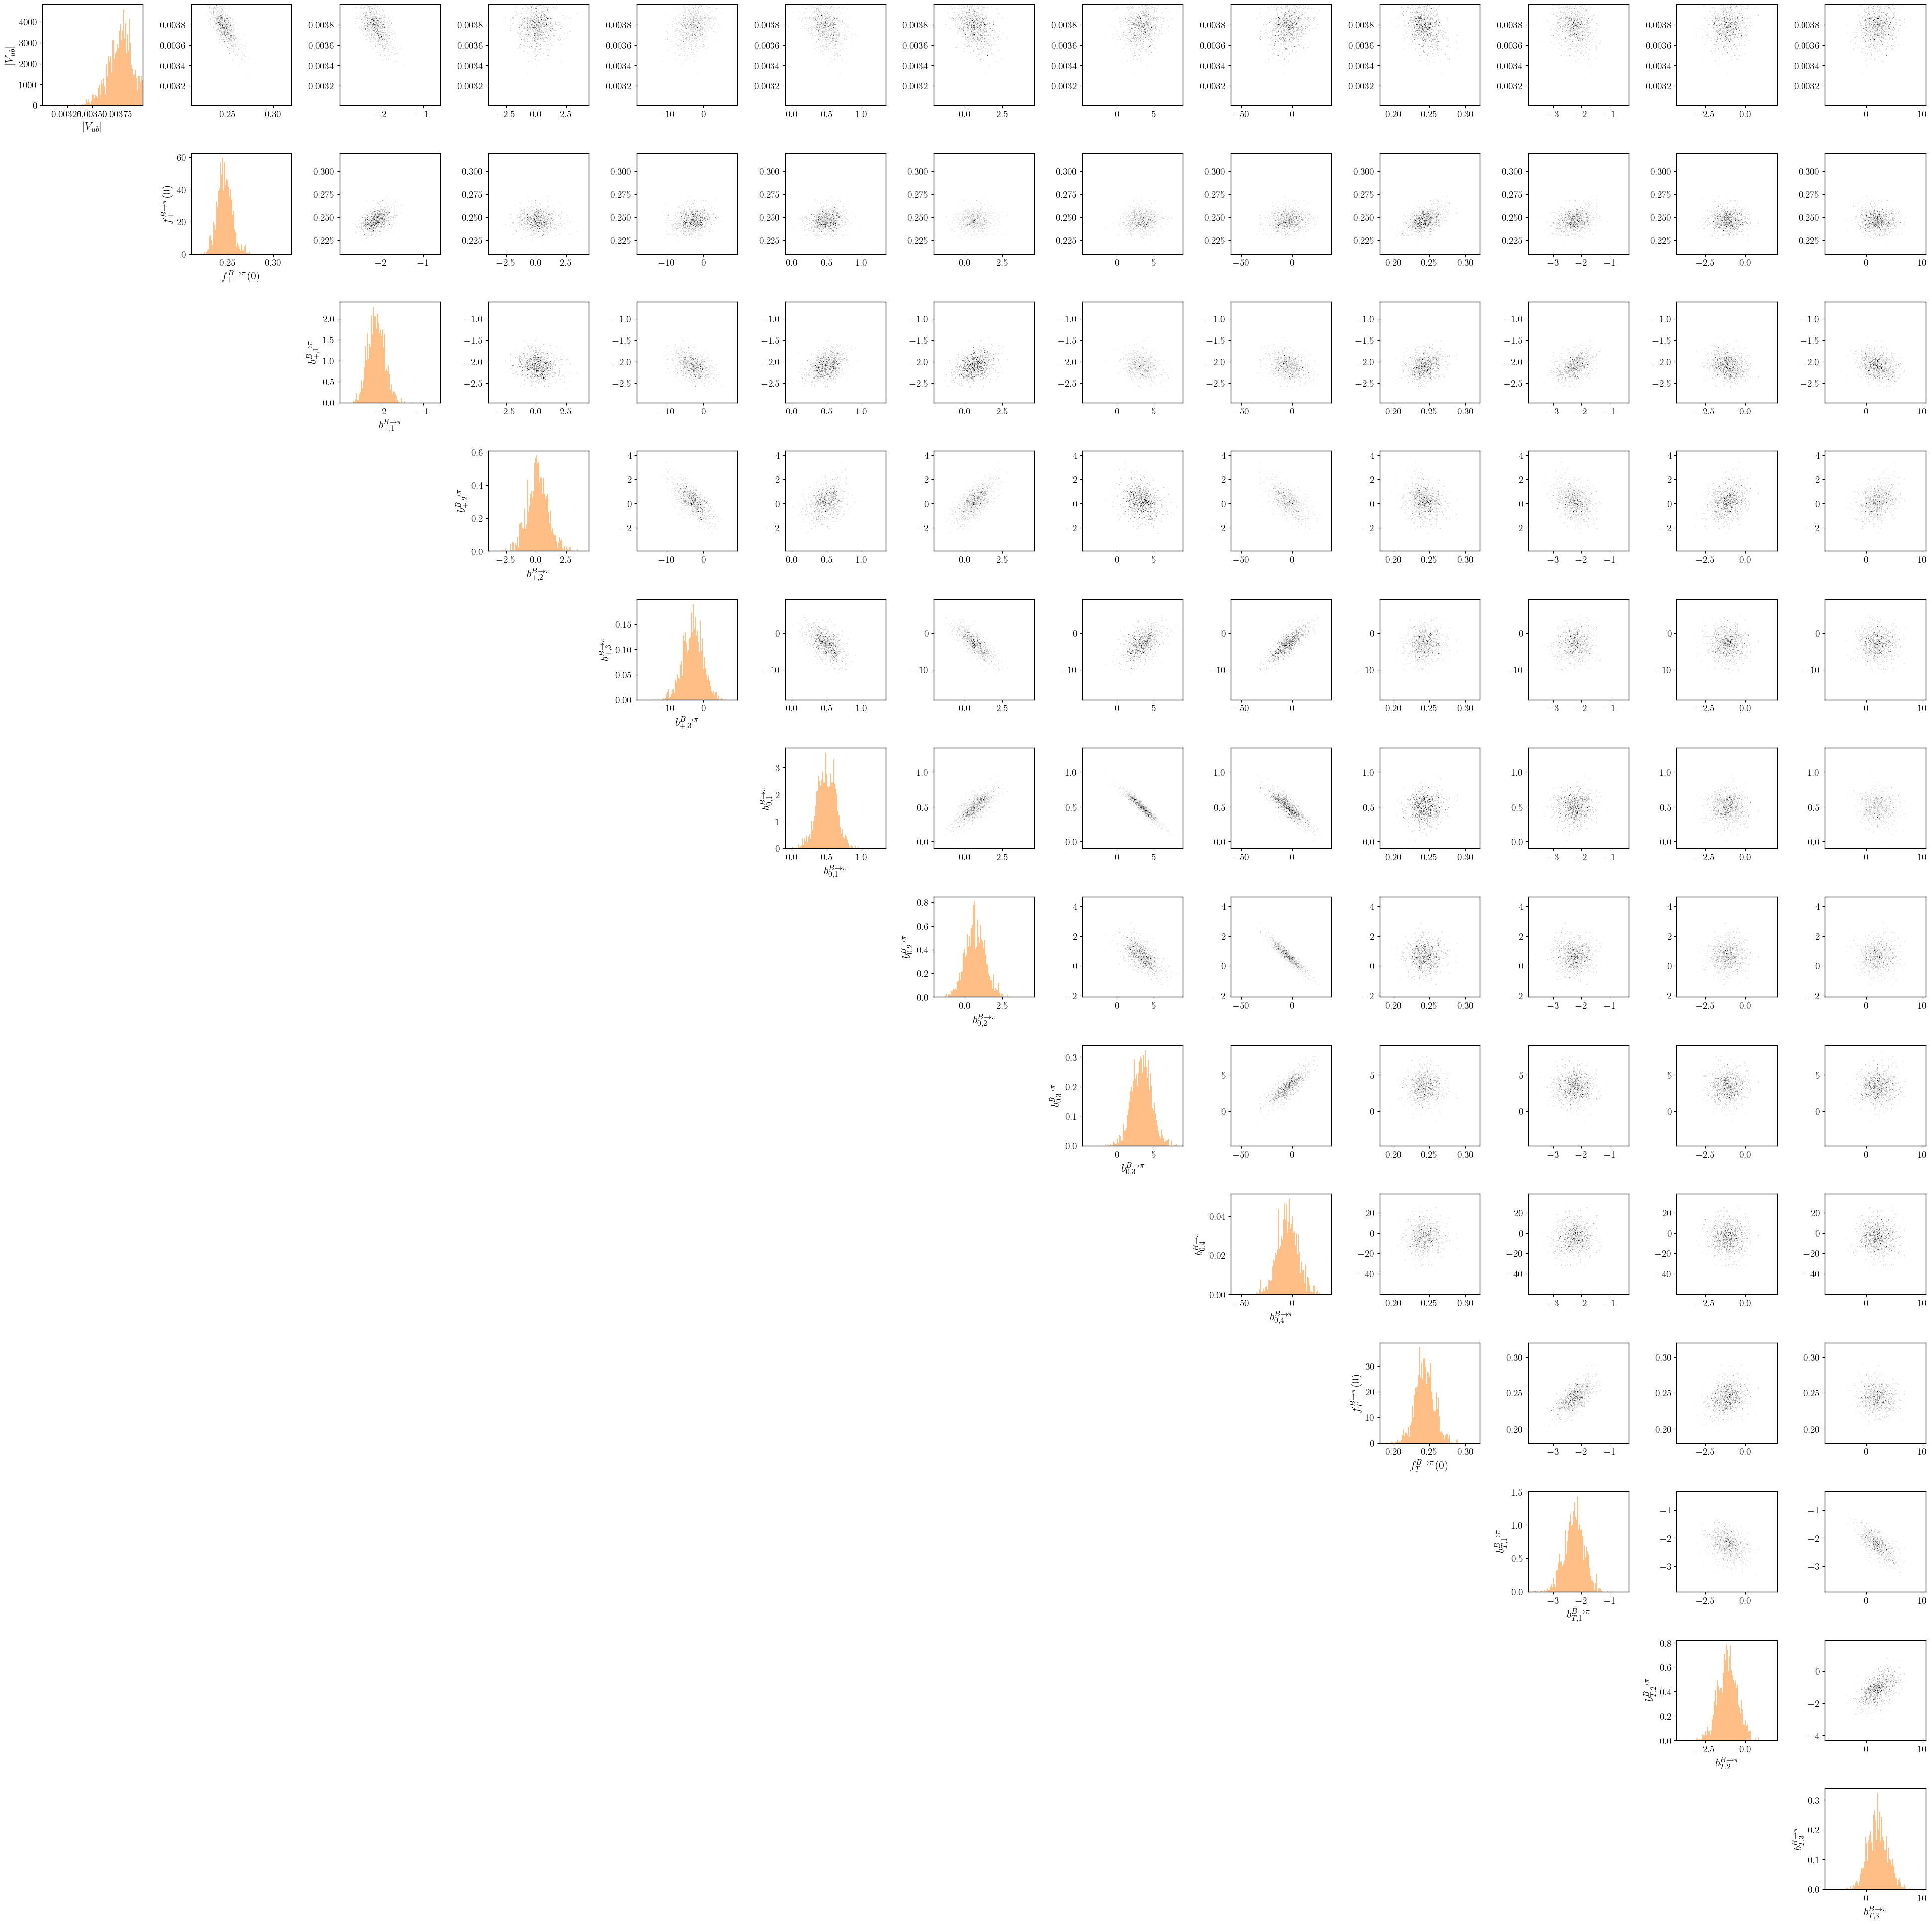

In [6]:
eos.tasks.corner_plot(analysis_file=af, posterior='CKM-pi', base_directory=BASE_DIRECTORY, format=['pdf', 'png'])

We can also generate posterior-predictive samples. Here we produce samples for the branching ratio of the leptonic decay $\bar{B} \to \ell^- \bar{\nu}$:

In [7]:
eos.tasks.predict_observables(analysis_file=af, posterior='CKM-pi',
                              prediction='leptonic-BR-CKM',
                              base_directory=BASE_DIRECTORY)

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('CKM-pi/pred-leptonic-BR…

These samples can be analyzed as described in the [inference](inference.rst) notebook, e.g. with:

In [8]:
predictions = eos.data.Prediction('./CKM-pi/pred-leptonic-BR-CKM')
lo, mi, up = eos.Plotter._weighted_quantiles(predictions.samples[:, 0], # Here 0 gives access to the prediction with the option l = e
                                             [0.15865, 0.5, 0.84135],
                                             predictions.weights)

from IPython.display import Markdown as md
md(f"""$\\mathcal{{B}}(\\bar{{B}} \\to e^- \\bar{{\\nu}}_e) = \
        {10**12*mi:.2f} ^ {{+{10**12*(up-mi):.2f}}} _ {{{10**12*(lo-mi):.2f}}} \\times 10^{{-12}}$
        (from a naive sampling)""")

$\mathcal{B}(\bar{B} \to e^- \bar{\nu}_e) =         9.68 ^ {+0.52} _ {-0.62} \times 10^{-12}$
        (from a naive sampling)